# **AM 207**: Homework 3

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday March 24th, 2016**

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW3.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW3.tar.gz or AM207_YOURNAME_HW3.zip


### Have Fun!
_ _ _ _ _

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

/Users/Grace/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Problem 1: Employee Satisfaction Improvement
This problem is going to explore the differences between complete pooling, unpooling and partial pooling for a normal model with observed standard deviations. 

You are working for a consulting firm which is trying to find a good strategy to improve employee satisfaction for their customers. Your company ran pilot studies in eight different customer companies and measured the improvement in employee satisfaction after the plan had been implemented for two years. The data you are given is the mean and standard deviation of the satisfaction improvement, measured by a survey. 
You follow the nature of your data by modeling the effect of the strategie with a normal model. To simplify things you can assume that the different standard deviations are an effect of different sample sizes, and that there is actually one underlying observation variance:

$$ \sigma_j^2 = \frac{\sigma^2}{n_j}$$

Thus the difference in the observed standard deviations in the survey results are caused by having different numbers of survey answers $n_j$. 

Discuss, create and compare three different solutions for your model using PYMC or another sampling method of your choice:

* complete pooling
* unpooling
* partial pooling

In [2]:
# Here is the data
data = np.double(np.array([[29.5,18.4],[6.3,12.7],[-3.9,15.9],[7.2,10.2],[-2.1,9.0],[1.8,12.1],[19.6,7.3],[12,18.6]]))
data_means = data[:,0]
data_std = data[:,1]

In [24]:
# ===============================================
# to define TAU value for later use in pm.Normal
# ===============================================
data_tau = 1.0/data_std**2

## 1) Complete Pooling

* For complete pooling, we assume that there is only one $\theta$ among the whole data
* For prior, let's assume that our $\theta$ will follow the normal distribution as well, to make it conjugate prior.
* Based on our belief, the mean of $\theta$ would be **0** since some companies showed improvement, whereas other companies showed decrement in satisfaction.
* The variance of $\theta$ would be very large number as we think there are improvement in some companies, and decrement in other companies. I supposed it to be **1000**.

So our posterior will look like this : 
$$
P(\theta | \{y\}) = \prod_{j=1}^{8} P(y_{j} | \theta) P(\theta)
$$
$$
= \prod_{j=1}^{8} N(y_{j} ; \theta, \sigma_{j}^{2}) N(\theta; 0, 1000)
$$

In [50]:
theta_complete_pooling = pm.Normal('theta_complete_pooling', 0, 1.0/1000)
likelihood_complete_pooling = pm.Normal('likelihood_complete_pooling', theta_complete_pooling, data_tau, observed=True, value=data_means)

model = pm.Model([theta_complete_pooling, likelihood_complete_pooling])
mcmc = pm.MCMC(model)
mcmc.sample(iter=100000, burn=1000)

 [-----------------100%-----------------] 100000 of 100000 complete in 4.1 sec

In [51]:
mcmc.summary()


theta_complete_pooling:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	8.807            3.921            0.03           [  0.822  16.298]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	1.059            6.188           8.833          11.362        16.561
	


Plotting theta_complete_pooling


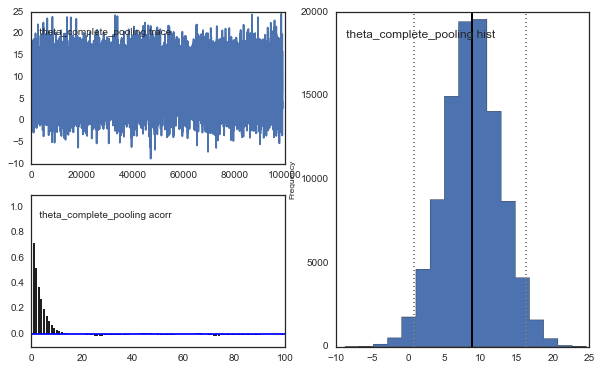

In [52]:
pm.Matplot.plot(theta_complete_pooling)

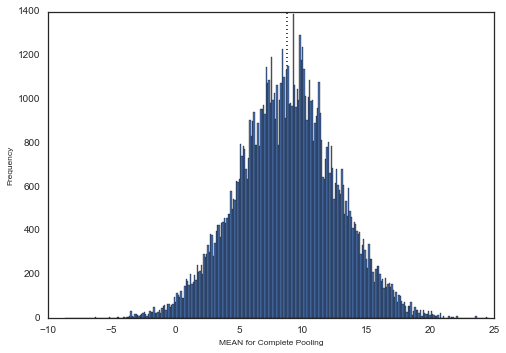

In [104]:
pm.Matplot.gof_plot(theta_complete_pooling, data_means.mean(), name='MEAN for Complete Pooling')

## 2) Unpooling

* For unpooling, we assume that there are 8 different $\theta$s among the whole data
* For prior, we set hyperparameter for $\theta_{j}$ itself, which are $\mu_{j}$ and $\tau_{j}$. And $\theta_{j}$ will follow the normal distribution as well, to make it conjugate prior.
* For hyperparameter, since it's unpooling, there should be 8 different $\mu_{j}$ and $\tau_{j}$. And I assumed that they are from Uniform distribution. 

So our posterior will look like this : 
$$
P(\theta | \{y\}) = \prod_{j=1}^{8} P(y_{j} | \theta_{j}) P(\theta_{j} | \mu_{j}, \tau_{j}) P(\mu_{j}, \tau_{j}) 
$$
$$
= \prod_{j=1}^{8} N(y_{j} ; \theta_{j}, \sigma_{j}^{2}) N(\theta_{j}; \mu_{j}, \tau_{j}) Uniform(\mu_{j}) Uniform(\tau_{j})
$$

In [65]:
N = data.shape[0]

mu_unpooling = pm.Container([pm.Uniform('mu_%i'%i, -50, 50) for i in range(N)])
tau_unpooling = pm.Container([pm.Uniform('tau_%i'%i, 1.0/2000, 1.0/100) for i in range(N)])
thetas_unpooling = pm.Container([pm.Normal('unpooling_theta_%i'%i, mu_unpooling[i], tau_unpooling[i]) for i in range(N)])
likelihood_unpooling = pm.Normal('likelihood_unpooling', thetas_unpooling, data_tau, observed=True, value=data_means)

model = pm.Model([thetas_unpooling, likelihood_unpooling, mu_unpooling, tau_unpooling])
mcmc = pm.MCMC(model)
mcmc.sample(iter=100000, burn=1000)

 [-----------------100%-----------------] 100000 of 100000 complete in 77.2 sec

In [79]:
for i in range(N):
    thetas_unpooling[i].summary()


unpooling_theta_0:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	24.564           16.023           0.196          [ -7.709  54.449]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-8.408           14.047          25.106         35.714        54.075
	

unpooling_theta_1:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	6.193            12.387           0.119          [-17.391  31.005]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-18.154          -2.137          6.199          14.637        30.323
	

unpooling_theta_2:
 
	Mean             SD               MC Error        9

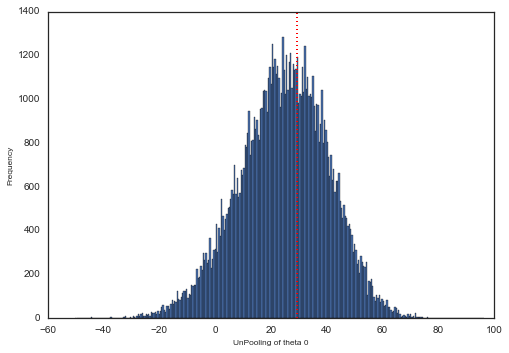

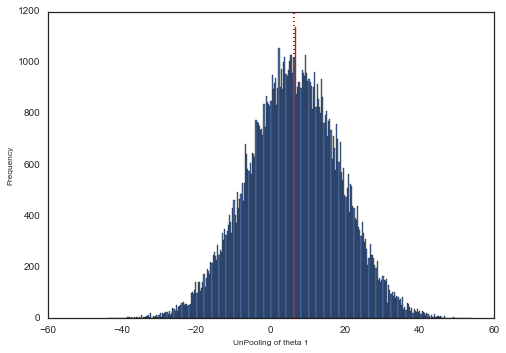

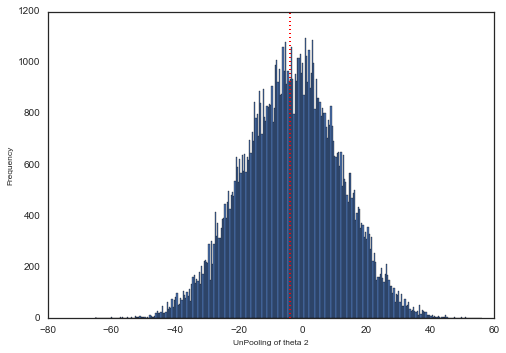

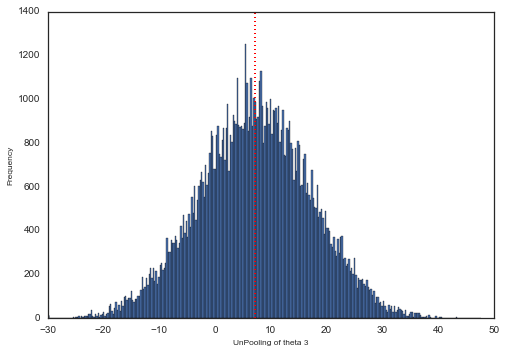

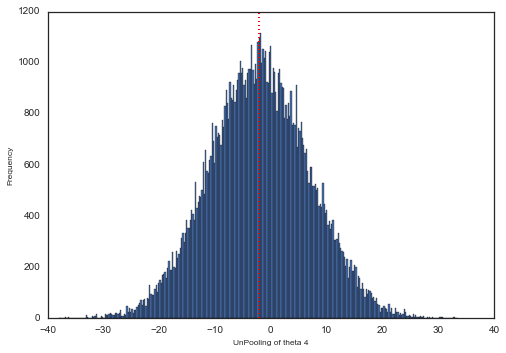

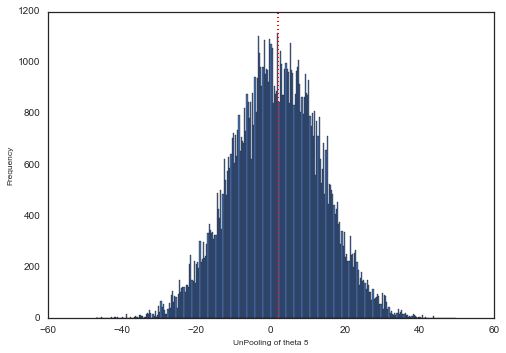

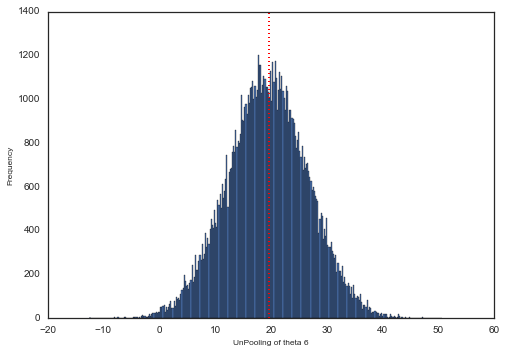

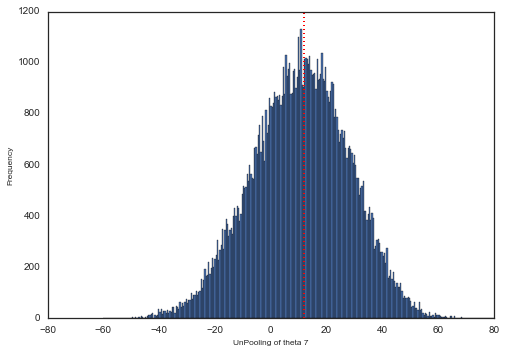

In [105]:
for i in range(N):
    pm.Matplot.gof_plot(thetas_unpooling[i], data_means[i], name='UnPooling of theta %i' %i)

## 3) Partial pooling

* For partial pooling, we assume that there are 8 different $\theta$s that come from a common distribution of hyperparmeters.
* For prior, we set a common hyperparameter for $\theta_{j}$ itself, which are $\mu$ and $\tau$. And $\theta_{j}$ will follow the normal distribution as well, to make it conjugate prior.
* For hyperparameter, since it's partial pooling, there should be only one common $\mu$ and $\tau$. And I assumed that they are from Uniform distribution. 

So our posterior will look like this : 
$$
P(\theta | \{y\}) = \prod_{j=1}^{8} P(y_{j} | \theta_{j}) P(\theta_{j} | \mu, \tau) P(\mu, \tau) 
$$
$$
= \prod_{j=1}^{8} N(y_{j} ; \theta_{j}, \sigma_{j}^{2}) N(\theta_{j}; \mu, \tau) Uniform(\mu) Uniform(\tau)
$$

In [95]:
N = data.shape[0]

mu_partial_pooling = pm.Uniform('mu_partial_pooling', -50, 50)
tau_partial_pooling = pm.Uniform('tau_partial_pooling', 1.0/2000, 1.0/100)
thetas_partial_pooling = pm.Container([pm.Normal('partial_pooling_theta_%i'%i, mu_partial_pooling, tau_partial_pooling) for i in range(N)])
likelihood_partial_pooling = pm.Normal('likelihood_partial_pooling', thetas_partial_pooling, data_tau, observed=True, value=data_means)

model = pm.Model([thetas_partial_pooling, likelihood_partial_pooling, mu_partial_pooling, tau_partial_pooling])
mcmc = pm.MCMC(model)
mcmc.sample(iter=100000, burn=1000)

 [-----------------100%-----------------] 100000 of 100000 complete in 46.6 sec

In [96]:
for i in range(N):
    thetas_partial_pooling[i].summary()


partial_pooling_theta_0:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	14.894           11.316           0.097          [ -6.391  38.083]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-6.679           7.354           14.602         22.318        37.813
	

partial_pooling_theta_1:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	7.164            9.317            0.074          [-11.246  25.27 ]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-11.092          0.907           7.204          13.39         25.513
	

partial_pooling_theta_2:
 
	Mean             SD              

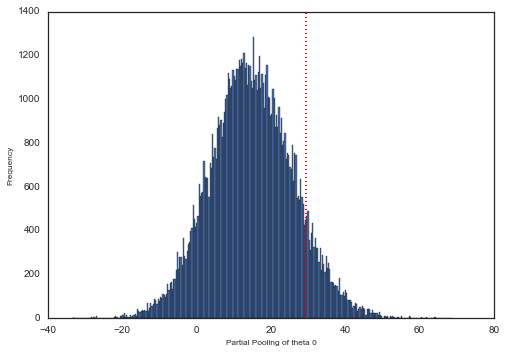

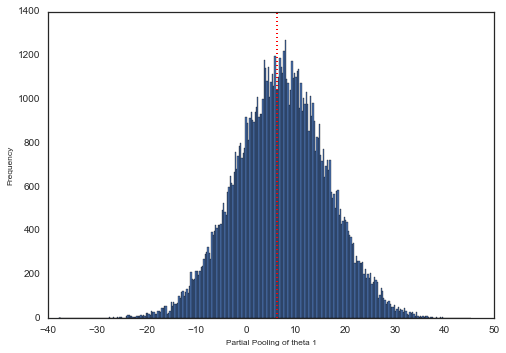

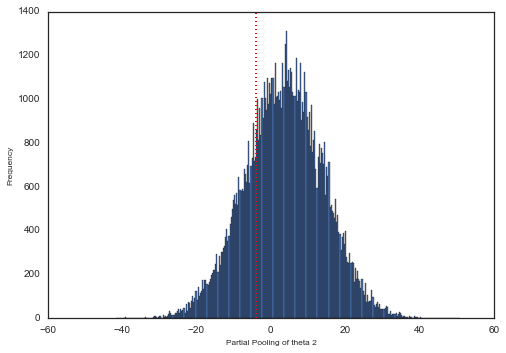

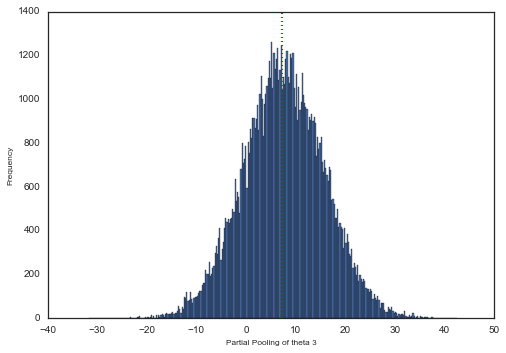

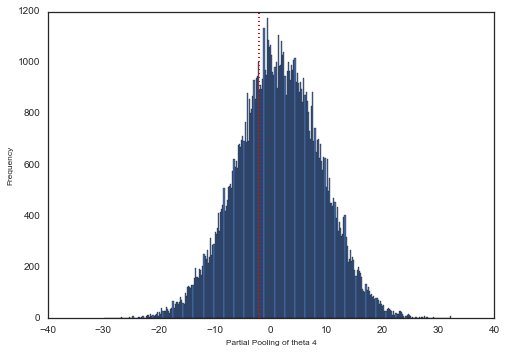

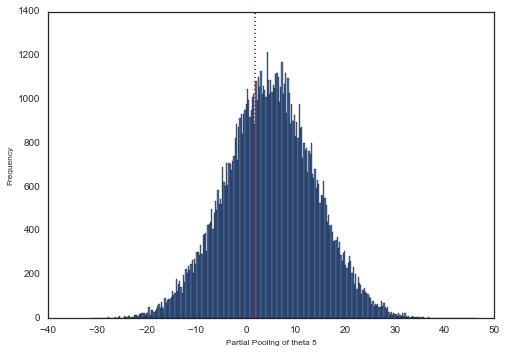

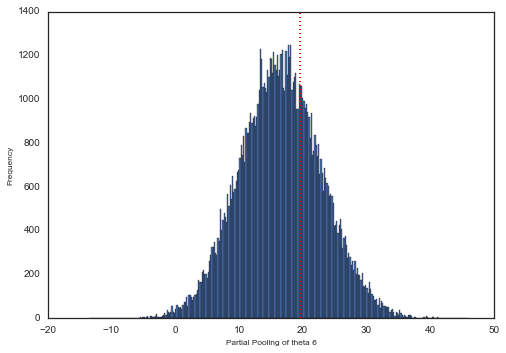

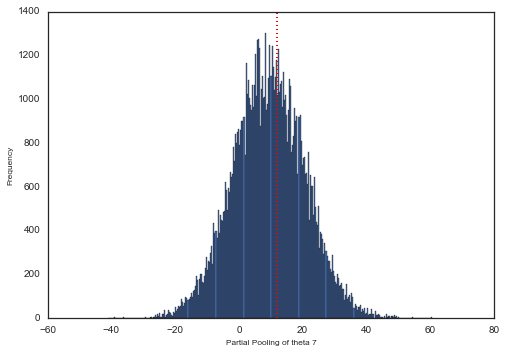

In [109]:
for i in range(N):
    pm.Matplot.gof_plot(thetas_partial_pooling[i], data_means[i], name='Partial Pooling of theta %i' %i)

# Problem 2: Motif Finding Using Gibbs

One interesting problem in bioinformatics is that of finding common subsequences of nucleotid bases (these subsequences are called motifs) that repeat themselves within larger DNA sequences. The problem is relevant for genetics because locating the positions of these motifs within the DNA sequence helps in the understanding of how genes are regulated.

Suppose that you are a biologist who is analyzing genetic material collected in a nearby asteroid. The DNA of this extraterrestrial form of life is formed as a sequence of $n_B = 5$ nucleotide bases. Let us label these extraterrestrial nucleotides and put them in a vector $\mathbf{b} = [\rm{M}, \rm{0}, \rm{2}, \rm{A}, \rm{7}]$. You have a DNA sample $\mathcal{S}$ consisting of $p=20$ sequences of DNA, each of them with a lenght $l=200$ nucleotide bases that you can find in <a href="HW3/Sequences_new.dat">this file</a>. Each row of the file is a DNA sequence. You are asked to find a motif of $q = 5$ consecutive nucleotides hidden in the background that appears to repeat itself very often in the DNA you were given, but that appears only once in each of the sequences.

Let us formalize the problem. The starting positions of the motif within each sequence (our missing data in the problem) can be represented by the set of random variables:

$$
\mathcal{A} = \left\{a_k, k = 1,...,p\right\}
$$

The motif has to start somewhere within the sequences and so for each sequence $\mathcal{S_k}$:

$$
\sum_{i=1}^{l}P(a_k=i) = 1
$$

What we are after is the joint distribution $P(\mathcal{A}|\mathcal{S})$ for the motif alignment (i.e., its starting position) being $a_k$ for sequence $\mathcal{S}_k$. As shown in [this paper](http://www.cs.cmu.edu/~epxing/Class/10810/readings/liu.pdf), for each sequence $\mathcal{S}_k$ (think of each sequence as a dimension of our parameter space) we can obtain the conditional probability: 

$$
P(a_k=i|\mathcal{A_{\hat{k}}},\mathcal{S})=\frac{1}{Z}\prod_{j=1}^q\left(\frac{\mathbf{\hat{\theta}_j}}{\mathbf{\hat{\theta}_0}}\right)^{s_{i+j-1}}
$$

where $\mathcal{A_{\hat{k}}}$ refers to the alignments in all sequences other than $\mathcal{S}_k$, and $Z$ is a normalization factor. Of the other quantities, $s_x$ is a vector index for the *x-th* position in the sequence, with the same length as $\mathbf{\hat{\theta_j}}$ and $\mathbf{b}$. It takes a value of 1 at the entry that in $\mathbf{b}$ corresponds to the base at position $x$ and 0 for all other entries. Finally, vectors $\mathbf{\hat{\theta_j}}$ and $\mathbf{\hat{\theta_0}}$ contain respectively the probabilities of observing the $q$ bases at the corresponding position of the current sequence, and the probabilities of finding the same bases in the background. It is important to note that the power, division, and multiplication of vectors in the equation above is performed entry-wise.

Your only task is to design a Gibbs algorithm that samples the joint probability $P(\mathcal{A}|\mathcal{S})$. Your algorithm should converge and provide the alignments of the motif and the secret motif itself. Here are some hints/tasks that should help you and that will help the TF grading your homework:

## (a) Describe the equation for the conditional probabilities in your own words, and make sure you understand it before you code anything. Be as explicit as possible.

## (b)-1. Start by assigning random starting positions for the $q$-long motif in all sequences.

In [117]:
# ===============
# read the file
# ===============
sequence_file = open('HW3/Sequences_new.dat', 'r')
sequence_data = []
for line in sequence_file:
    sequence_data.append(line.rstrip())

In [140]:
p = len(sequence_data)
print "p = ", p
l = len(sequence_data[0])
print "l = ", l
q = 5
print "q = ", q
b = ['M', '0', '2', 'A', '7']
print "b = ", b

p =  20
l =  200
q =  5
b =  ['M', '0', '2', 'A', '7']


In [131]:
# =================================
# Assign random Starting Positions from [0, 196)
# =================================
starting_positions = np.random.randint(low=0, high=196, size=20)
starting_positions

array([ 90,  97,  19,  85, 141,  47, 160,   3, 146, 148,  26, 109, 185,
        67,  65, 192,  16, 162, 174, 192])

## (b)-2. Then exclude a particular sequence $S_k$ (your current sequence) and use the remaining sequences to construct $\mathbf{\Theta}$ as a probability matrix from counting the number of times that the *i-th* base appears in position $j$ of the motif given the current alignments. Construct also a vector $\mathbf{\hat{\theta_0}}$ from counting the number of times that the *i-th* base appears in the background. Note that the vectors $\mathbf{\hat{\theta_j}}$ are the columns of matrix $\mathbf{\Theta}$.

For this step, I'll exclude **k=0th** sequence, and use the other 19 sequences to construct $\mathbf{\Theta}$ and $\theta_0$

In [161]:
k = 0
big_theta = np.zeros((5,5))
theta0 = np.zeros(5)
for i in range(p):
    if i == k:
        continue
    else :
        # =====================
        # construct BIG_THETA
        # =====================
        start_pos = starting_positions[i]
        tmp_motif = sequence_data[i][start_pos:start_pos+5]
        print start_pos,'\t', tmp_motif, '\t', start_pos+5
        
        for j in range(len(tmp_motif)):
            row = b.index(tmp_motif[j]) # base 'M' determines which row it is
            col = j # position in motif 'j' determines which column it is
            big_theta[row][col] += 1
            
        # =====================
        # construct THETA0
        # =====================
        tmp_background = sequence_data[i][:start_pos] + sequence_data[i][start_pos+5:] # it should be length 195
        
        for base in tmp_background:
            index = b.index(base) # base 'M' determines which index it should be in theta0
            theta0[index] += 1
print "--------------------"
print 'BIG_THETA'
print "--------------------"
print big_theta

print "--------------------"
print 'Theta_0'
print "--------------------"
print theta0

97 	M0M77 	102
19 	20027 	24
85 	070A7 	90
141 	M7AA7 	146
47 	227A7 	52
160 	07AAM 	165
3 	02A22 	8
146 	72A7M 	151
148 	7022A 	153
26 	M002A 	31
109 	72A27 	114
185 	2M720 	190
67 	72220 	72
65 	70777 	70
192 	27022 	197
16 	A0AA7 	21
162 	2007A 	167
174 	A2A77 	179
192 	7AAA0 	197
--------------------
BIG_THETA
--------------------
[[ 3.  1.  1.  0.  2.]
 [ 3.  7.  5.  0.  3.]
 [ 5.  6.  2.  8.  2.]
 [ 2.  1.  8.  6.  3.]
 [ 6.  4.  3.  5.  9.]]
--------------------
Theta_0
--------------------
[ 713.  720.  746.  749.  777.]


## (c) From $\mathbf{\Theta}$ and $\mathbf{\theta_0}$, derive the conditional probability over all possible alignments for your current sequence and draw a sample from it. This sample will be your updated alignment for the current sequence.

$$
P(a_k=i|\mathcal{A_{\hat{k}}},\mathcal{S})=\frac{1}{Z}\prod_{j=1}^q\left(\frac{\mathbf{\hat{\theta}_j}}{\mathbf{\hat{\theta}_0}}\right)^{s_{i+j-1}}
$$

In [196]:
conditional_probability = np.ones(l-q) # 195 entries # l = 200, q = 5
for i in range(len(sequence_data[k])-q): # read each element in Sk sequence
    p_ak_i = 1.0
    for j in range(q):
        base = sequence_data[k][i+j]
        s_index = b.index(base) # if base is 'M' then j = 0 and only theta_1 will survive
        theta_j = big_theta[:, j]
        p_ak_i *= (theta_j/theta0)[s_index]
        
    conditional_probability[i] = p_ak_i
    
z = conditional_probability.sum() #normalization constant
conditional_probability = conditional_probability / z
print '----------------------------'
print 'A new sample according to the probability : ', np.random.choice(l-q, size=1, p=conditional_probability)
print '----------------------------'
print '195 conditional probabilities for k = 0 Sequence'
print '----------------------------'
print conditional_probability


----------------------------
A new sample according to the probability :  [186]
----------------------------
195 conditional probabilities for k = 0 Sequence
----------------------------
[ 0.00197492  0.          0.          0.0021315   0.          0.
  0.00245575  0.          0.          0.          0.          0.
  0.00198762  0.          0.0046486   0.02342893  0.          0.          0.
  0.          0.00295477  0.00085251  0.          0.01019392  0.00176034
  0.          0.00861516  0.06513062  0.00775365  0.01163047  0.
  0.01666792  0.          0.          0.00562611  0.01215239  0.0096522
  0.02165992  0.          0.00093509  0.          0.00782289  0.01563846
  0.00542459  0.          0.00360672  0.01127063  0.          0.00112348
  0.00048697  0.          0.          0.          0.          0.          0.
  0.00049972  0.          0.00181883  0.00407418  0.          0.00116873
  0.          0.0076734   0.          0.0067597   0.00135374  0.00531093
  0.          0.          0

## (d) Iterate over all $p$ sequences. Such iteration over sequences is only one Gibbs iteration. After enough Gibbs iterations you should start noticing that the algorithm has converged.

In [230]:
N=1000
gibbs_samples_trace = np.zeros((N, p)) #this will store the trace of starting positions after one gibbs sampling
starting_positions = np.random.randint(low=0, high=196, size=20)

for iteration in range(N):
    for k in range(p):
        # =====================
        # construct BIG_THETA + Theta0
        # =====================
        big_theta = np.zeros((5,5))
        theta0 = np.zeros(5)
        for i in range(p):
            if i == k:
                continue
            else :            
                start_pos = starting_positions[i]
                tmp_motif = sequence_data[i][start_pos:start_pos+5]

                for j in range(len(tmp_motif)):
                    row = b.index(tmp_motif[j]) # base 'M' determines which row it is
                    col = j # position in motif 'j' determines which column it is
                    big_theta[row][col] += 1

                tmp_background = sequence_data[i][:start_pos] + sequence_data[i][start_pos+5:] # it should be length 195

                for base in tmp_background:
                    index = b.index(base) # base 'M' determines which index it should be in theta0
                    theta0[index] += 1

        # =====================
        # compute conditional probability
        # =====================
        conditional_probability = np.ones(l-q) # 195 entries # l = 200, q = 5
        for i in range(len(sequence_data[k])-q): # read each element in Sk sequence
            p_ak_i = 1.0
            for j in range(q):
                base = sequence_data[k][i+j]
                s_index = b.index(base) # if base is 'M' then j = 0 and only theta_1 will survive
                theta_j = big_theta[:, j]
                p_ak_i *= (theta_j/theta0)[s_index]

            conditional_probability[i] = p_ak_i

        z = conditional_probability.sum() #normalization constant
        conditional_probability = conditional_probability / z

        # =====================
        # update alignment
        # =====================
        new_start_pos = np.random.choice(l-q, size=1, p=conditional_probability)[0]
        starting_positions[k] = new_start_pos
    
    # =====================
    # store the trace info
    # =====================
    gibbs_samples_trace[iteration, :] = starting_positions


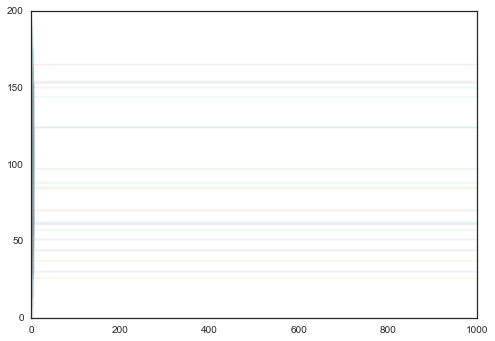

In [231]:
for i in range(p):
    plt.plot(gibbs_samples_trace[:, i], alpha=0.1)
plt.show()

In [237]:
print gibbs_samples_trace[999, :]
print gibbs_samples_trace[998, :]

[  62.  150.   30.  153.   26.   57.   51.   97.   70.  154.   37.  124.
   61.   85.  165.  124.   84.  144.   44.   88.]
[  62.  150.   30.  153.   26.   57.   51.   97.   70.  154.   37.  124.
   61.   85.  165.  124.   84.  144.   44.   88.]


In [234]:
for i in range(p):
    start_pos = starting_positions[i]
    tmp_motif = sequence_data[i][start_pos:start_pos+5]
    print start_pos,'\t', tmp_motif, '\t', start_pos+5

62 	AM207 	67
150 	AM207 	155
30 	AM207 	35
153 	AM207 	158
26 	AM207 	31
57 	AM207 	62
51 	AM207 	56
97 	AM207 	102
70 	AM207 	75
154 	AM207 	159
37 	AM207 	42
124 	AM207 	129
61 	AM207 	66
85 	AM207 	90
165 	AM207 	170
124 	AM207 	129
84 	AM207 	89
144 	AM207 	149
44 	AM207 	49
88 	AM207 	93


# Problem 3: Optimizing Hand Luggage

You are going on a trip and have to optimize your hand luggage, but thanks to your cheap flight ticket, the weight of the hand lugagge is restricted and you are sure the airline will enforce the upper limit. You have a set of presents that you want to bring to the relatives you are visiting, but you have to notice that they don't all fit into your suitcase. 

This problem is also called the knapsack problem: given a set of items, each has its weight and value, determine which items should be included into your suitcase, so that the total weight does not exceed some value $W$ and the total value is maximal. The kind of the knapsack problem when each item can be included into the collection at most once is called the 0/1 knapsack problem. Your task is to solve this problem using simulated annealing. 

Implement simulated annealing to solve this problem with the list of items below. Which ones would you pick for your suitcase? Plot and discuss your optimization scheme and results. 
Compare your solution to a greedy algorithm, which sorts the items by the ratio $\frac{v_i}{w_i}$ and puts them into the suitcase consecutively.

In [5]:
# here is your data:

#number_of_data_points
N = 100

#total_weight_limit 
W = 3000

# weight of all the different items
w = np.array([  38,  236,  909,   73,  768,  906,  716,  646,  848,  961,  145,
        130,  973,  584,  750,  509,  391,  282,  179,  277,  255,  358,
        915,  469,  908,  253,  491,  669,  926,  399,  563,  581,  216,
        984,  754,  504,  479,  865,   87,  142,  394,    8,  320,  830,
        535,  314,  514,  897,  317,  210,  265,  729,  654,  628,  432,
        634,  457,  543,   72,  388,  455,  918,  562,  314,  516,  965,
        793,  498,   44,  589,   27,  821,  337,  622,  884,  298,  467,
         16,   65,  197,   26,  368,  739,  472,  904,  283,  666,  617,
         23,  778,  708, 1000,  127,  280,  382,  357,  156,  934,  314,
        596])

# value of all different items
v = np.array([36, 38, 30, 32, 40, 45, 45, 37, 49, 40, 44, 30, 31, 47, 43, 33, 30,
       43, 36, 50, 36, 32, 42, 41, 37, 43, 38, 41, 42, 41, 50, 34, 37, 37,
       43, 34, 46, 48, 30, 43, 40, 47, 37, 40, 50, 30, 42, 31, 39, 48, 49,
       31, 32, 42, 37, 32, 40, 30, 39, 48, 36, 32, 37, 37, 46, 45, 35, 47,
       40, 50, 46, 35, 43, 47, 48, 31, 50, 40, 30, 37, 30, 49, 47, 44, 43,
       50, 50, 41, 36, 43, 45, 39, 32, 37, 35, 34, 35, 38, 43, 47])

# Problem 4: Confusing Classifications

You are a graduate student conducting research in image processing.  You want to test out your latest algorithm, which you decide to call "Ultra-Multilayer Hierarchical Super Convolutionary Neural Network."  However, in order to test out your algorithm, you need a sizable training data set. Luckly, your advisor has generously given you over 10 GB of over one million stock photos of cats and dogs.  Unfortunately, none of the images are labelled.  Fantastic!  You enjoy looking at photos of puppies and kittens in your spare time anyways so you decide to dedicate this entire weekend to labeling all of them. 

<table>
<tr>
 <td><img src="HW3/cat.jpeg" width=150>
 </td>
 <td><img src="HW3/dog.jpeg" width=150>
 </td>
</tr>
</table>

However, after spending two hours looking over hundreds of images, these puppies and kittens are no longer looking so cute.  In fact, you are starting to get disgusted at the idea of looking at another picture of these furry creatures.  

At this time, you decide to tap into the "power of the crowd" by farming out the labeling task to the workers of Amazon Mechanical Turk (MTurk). You decide to hire 3 MTurk workers.  However, you're not sure if these workers are reliable. So, how can you quantify the competency of the workers? In this problem you will develop a model to access the general difficulty of labeling the images of your two classes. 

Classifying items in general can be hard even for humans.  Some items just look alike, even if they actually are from two different classes. The difficulty in categorizing items of a specific class in relation to other classes is summarized by a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix):

$$ \Theta = \left( 
\begin{array}{cc}
1.0 & 0.0 \\
0.5 & 0.5
\end{array}
\right ) $$

This confusion matrix indicates that items of class 1 are very easy to classify, and always correctly labeled, whereas items of class 2 are very hard to classify and labels are basically just random guesses between the two possibilities. 

The models we discussed so far in homework and lecture were pretty low in dimensions. This problem is going to show you that the number of dimensions can grow very fast for some models, making a good sampling strategy crucial. We will only be able to explore a very minimal version of the problem, because of our limited computational resources, but it should be immediately clear how this model would scale for a greater number of classes, workers, and/or items.

Develop a Bayesian model that takes as input a set of (possible erroneous) item labelings and infer the underlying confusion matrix and the true label each data point. To make the model manageable by your laptop, use only one underlying confusion matrix (in principle different people could have different difficulties) two classes for the labels (the confusion matrix is 2x2), and a maximum of 150 data points. 

The model you are after is displayed in the following dependency graph:
<img src="HW3/confusion_model.png" alt="confusion matrix model" width=300>


$$\rho \sim Dir(\alpha) $$

$$z_i \sim Multinomial(\rho)$$

\begin{equation}
\Lambda = \begin{bmatrix}
 \lambda_1 \\
 \lambda_2 \\
\end{bmatrix}
\end{equation}

$$\Theta_{(k,:)} \sim Dir(\lambda_k)$$

$$r_{i,j} \sim Multinomial(\Theta_{(z_i , : )}), \ \forall j \in \{1,...,J\}$$

You're given reports generated by the 3 workers, so $r_{i,1}$ is one label for item $r_i$ and $r_{i,2}$ is another label given from another worker. Note that if the confusion matrix is not the identity matrix then these labels can be different because the workers make mistakes. The arrows in the diagram indicate dependence. So the labelings you observe are dependent on the confusion matrix $\Theta$ and the underlying true label $z_i$ for each item. $N$ is the number of data points you have and as described above you should use $N \leq 150$.

You can see from the diagram that the model uses Multinomials with Dirichlet priors. 

1. Start by describing the model in terms of these distributions, what they mean and what this arrangement means for the form of the labels $z_i$. Discuss the meaning and influence of the hyperparameter $\alpha$ on the true labels of the data.

2. Discuss your selection of the hyperparameter $\Lambda$ and how that influences the confusion matrix $\Theta$.

3. Implement this Bayesian model and sample from the posterior to recover the underlying confusion matrix $\Theta$ and the distribution of the true labels $\rho$.  Note: $\Theta$ is shared by all three workers.

In [6]:
# Here is your data

reports = np.load("HW3/reports.npy")